# Heat Treatment

The following notebook was used to convert the `*.lvm` files produced by Bradley's tensile testing machine into mechanical properties data for the Lab 5 report.

The first step is to import the standard plotting, analysis, and numerical method libraries.

In [2]:
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

The next step is to get a look at the format of the ouptut from the tensile tester. Raw samples are in a folder called `sample data/`.

In [3]:
import glob

for file in glob.glob('sample data/*.lvm'):
    print(file)

sample data/10am_air_quench.lvm
sample data/10am_oil_quench.lvm
sample data/10am_untreated.lvm
sample data/10am_water_quench.lvm
sample data/10am_water_quench_0001.lvm
sample data/8am_air_quench.lvm


In [4]:
with open(file) as f:
    for line in f.readlines()[:30]:
        print(line.strip())

LabVIEW Measurement
Writer_Version	2
Reader_Version	2
Separator	Tab
Decimal_Separator	.
Multi_Headings	No
X_Columns	One
Time_Pref	Absolute
Operator	machine07
Date	2018/11/19
Time	09:07:52.2131250998842608932
***End_of_Header***

Channels	2
Samples	100	100
Date	2018/11/19	2018/11/19
Time	10:29:42.2131250998843631031	10:29:42.2131400995329192163
Y_Unit_Label	Lbf	Volts
X_Dimension	Time	Time
X0	9.0000000000000000E+0	9.0000000000000000E+0
Delta_X	0.010000	0.010000
***End_of_Header***
X_Value	Load-lbf	Strain-usn	Comment
9.000000	1209.167480	1935.205078
9.010000	1210.845947	1941.308594
9.020000	1219.573975	1953.515625
9.030000	1223.266602	1956.567383
9.040000	1216.552734	1953.515625
9.050000	1216.552734	1971.826172
9.060000	1224.609375	1950.463867


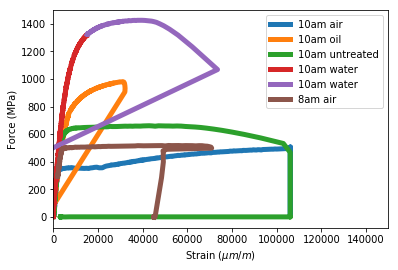

In [57]:
import re

diameter = 0.190
diameter = 0.190 * 2.54 / 100.
radius   = diameter / 2

area = np.pi * radius**2 

for file in glob.glob('sample data/*.lvm'):
    time, treatment = re.search(r'(\d\d?am).*(air|oil|untreated|water)', file).groups()
    
    df = pd.read_csv(file, skiprows=23, names=['t', 'F', 'e', 'comment'], delimiter='\t')
    plt.plot(df['e'], (df['F'] * 4.44) / area / 1e6, label=time + ' ' + treatment, linewidth=5)

plt.ylabel('Force (MPa)')
plt.xlabel('Strain ($\mu m/m$)')
plt.legend()

plt.xlim((0, 150000))
plt.show()

Clearly the data is going to require some individualized cleaning. We will import the files manually, extract the data, clean it, and save it as a `*.csv`.

,t,f,e,s
0,0.00,92.580749,3.076172e-06,5.061231e+06
1,0.01,101.540176,-2.438965e-05,5.551028e+06
2,0.02,122.445507,-1.523437e-05,6.693886e+06
3,0.03,97.060463,2.441400e-08,5.306129e+06
4,0.04,106.019894,-7.932129e-05,5.795926e+06


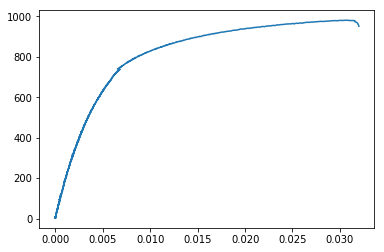

In [58]:
file = r'sample data/10am_oil_quench.lvm'

df = pd.read_csv(file, skiprows=23, delimiter='\t', names=['t', 'f', 'e', 'comment'])
df = df.drop(columns=['comment'])
df['t'] = df['t'] - min(df['t'])
df['e'] = df['e'] / 1e6

df = df[df['t'] < 18.63]

# Convert [lbf] to [N]
df['f'] = df['f'] * 4.44822

diameter = 0.190           # in.
diameter = diameter * 2.54 # cm.
diameter = diameter / 100  # m.
radius   = diameter / 2

area = np.pi * radius**2  # m2

df['s'] = df['f'] / area

plt.plot(df['e'], df['s'] / 1e6)

df.to_csv(r'processed data/oil.csv')
df.head()

,t,f,e,s
0,0.00,5378.642968,0.001935,2.940412e+08
1,0.01,5386.109158,0.001941,2.944494e+08
2,0.02,5424.933347,0.001954,2.965718e+08
3,0.03,5441.358964,0.001957,2.974698e+08
4,0.04,5411.494202,0.001954,2.958371e+08


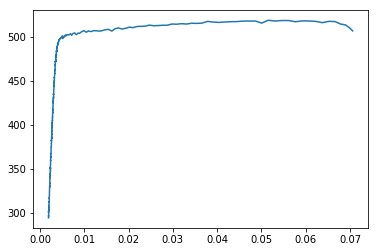

In [60]:
file = r'sample data/8am_air_quench.lvm'

df = pd.read_csv(file, skiprows=23, delimiter='\t', names=['t', 'f', 'e', 'comment'])
df = df.drop(columns=['comment'])
df['t'] = df['t'] - min(df['t'])
df['e'] = df['e'] / 1e6

df = df[df['t'] < 4.18]

# Convert [lbf] to [N]
df['f'] = df['f'] * 4.44822

diameter = 0.190           # in.
diameter = diameter * 2.54 # cm.
diameter = diameter / 100  # m.
radius   = diameter / 2

area = np.pi * radius**2  # m2

df['s'] = df['f'] / area

plt.plot(df['e'], df['s'] / 1e6)

df.to_csv(r'processed data/air.csv')
df.head()

,t,f,e,s
8,0.08,91.087513,0.000003,4.979599e+06
100,1.00,104.526653,0.000003,5.714293e+06
26,0.26,125.431984,0.000003,6.857152e+06
210,2.10,915.354841,0.000003,5.004088e+07
9,0.09,103.033417,0.000003,5.632661e+06


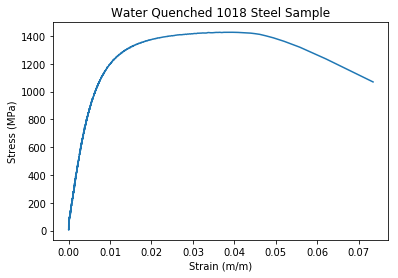

In [61]:
file1 = r'sample data/10am_water_quench.lvm'
file2 = r'sample data/10am_water_quench_0001.lvm'

df1 = pd.read_csv(file1, skiprows=23, delimiter='\t', names=['t', 'f', 'e', 'comment'])
df2 = pd.read_csv(file2, skiprows=23, delimiter='\t', names=['t', 'f', 'e', 'comment'])

df = pd.concat([df1, df2])
df = df.sort_values(by=['e'])



df = df.drop(columns=['comment'])
df['t'] = df['t'] - min(df['t'])
df['e'] = df['e'] / 1e6

df = df[df['t'] < 50]
df = df[df['e'] > 0]

# Convert [lbf] to [N]
df['f'] = df['f'] * 4.44822

diameter = 0.190           # in.
diameter = diameter * 2.54 # cm.
diameter = diameter / 100  # m.
radius   = diameter / 2

area = np.pi * radius**2  # m2

df['s'] = df['f'] / area

plt.title('Water Quenched 1018 Steel Sample')
plt.xlabel('Strain (m/m)')
plt.ylabel('Stress (MPa)')
plt.plot(df['e'], df['s'] / 1e6)

df.to_csv(r'processed data/water.csv')
df.head()

,t,f,e,s
0,0.00,94.073990,0.000039,5.142864e+06
1,0.01,113.486080,0.000027,6.204090e+06
2,0.02,106.019894,0.000015,5.795926e+06
3,0.03,110.499608,0.000027,6.040825e+06
4,0.04,111.992844,0.000027,6.122457e+06


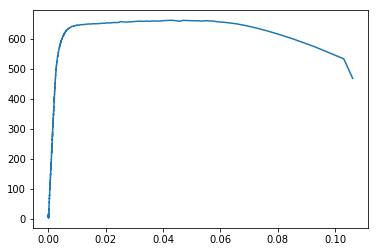

In [63]:
file = r'sample data/10am_untreated.lvm'

df = pd.read_csv(file, skiprows=23, delimiter='\t', names=['t', 'f', 'e', 'comment'])
df = df.drop(columns=['comment'])
df['t'] = df['t'] - min(df['t'])
df['e'] = df['e'] / 1e6

df = df[df['t'] < 14.23]

# Convert [lbf] to [N]
df['f'] = df['f'] * 4.44822

diameter = 0.190           # in.
diameter = diameter * 2.54 # cm.
diameter = diameter / 100  # m.
radius   = diameter / 2

area = np.pi * radius**2  # m2

df['s'] = df['f'] / area

plt.plot(df['e'], df['s'] / 1e6)

df.to_csv(r'processed data/untreated.csv')
df.head()

I am not particularly proud of the way I had to do that, but there were only four samples, and each of them had very unique problems. In the end, the do not repeat yourself (DRY) approach really only applies if it actually saves you time, and minimizes complexity. In this case, a semimanual approach was faster and clearler.

Now we can plot the *cleaned* data files.

air
su: 519 MPa
sy: 501 MPa
E:  125 GPa
----------

oil
su: 981 MPa
sy: 734 MPa
E:  156 GPa
----------

untreated
su: 662 MPa
sy: 611 MPa
E:  190 GPa
----------

water
su: 1427 MPa
sy: 1087 MPa
E:  191 GPa
----------



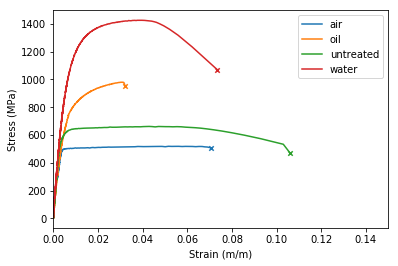

In [72]:
for file in glob.glob(r'processed data/*'):
    df = pd.read_csv(file)
    
    sample = file.split('.')[0].split('/')[1]
    
    plt.plot(df['e'], df['s'] / 1e6, label=sample)
    plt.scatter(df.iloc[-1]['e'], df.iloc[-1]['s'] / 1e6, marker='x', s=20)
    
    sigma_u = max(df['s'])
    E, _    = np.polyfit(df[df['e'] < 0.003]['e'], df[df['e'] < 0.003]['s'], 1)
    
    df['s_bar'] = E * (df['e'] - 0.002)
    df['error'] = np.power(df['s'] - df['s_bar'], 2)
    
    sigma_y = df.iloc[df['error'].idxmin()]['s']
    
    print(sample)
    print('su: {:.01f} MPa'.format(sigma_u / 1e6))
    print('sy: {:.0f} MPa'.format(sigma_y / 1e6))
    print('E:  {:.0f} GPa'.format(E / 1e9))
    print('-'*10)
    print()
    
plt.xlim((0, 0.15)) 
plt.xlabel('Strain (m/m)')
plt.ylabel('Stress (MPa)')
plt.legend()
plt.show()

In [11]:
import sys

sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'